In [468]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn import metrics
import warnings
warnings.filterwarnings( "ignore")

In [469]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive


# The Credit Card Problem
Credit cards have become an essential part of modern life, allowing people to make purchases and manage their finances conveniently. The integration of credit cards into everyday life is evident from the sheer number of shops going cashless and even small retail shops installing credit card terminals to cater to their customers' demands.

The increase in demand for credit cards places more stress on banks to expedite the process of approving credit cards. Manual methods are highly inefficient and can lead to potential loss of customers. Therefore, there is a need to use automation to refine this system.

It is important to note that it is also in the banks' interest to minimize losses. This means minimizing the issuance of cards to customers who are unable to repay their loans.

I will attempt to leverage modern machine learning tools to help tackle this problem.

## Data Set

I will attempt to strike a good balance between efficiency and minimizing losses. A credit score is determined by several factors:

1. Payment History (35%)
2. Credit Utilization (30%) 
3. Length of Credit history (15%)
4. Types of Credits used (10%)
5. Recent Credit Inquiries (10%)

These factors are evaluated, and a credit score is generated. A higher score indicates that the customer has better creditworthiness and is more likely to be approved for credit cards. However, the specific calculation method for determining the score is not publicly available.



## Methodology
In the following data sets, I have access to information regarding a bank's clients' personal information, their credit status, and history of credit status using this credit card. However, I lack information regarding factors 4 and 5 of the credit score metric described earlier.

Using this data, I will develop a novel credit score to determine whether clients should be issued a credit card in hindsight. This can then be used to predict which kinds of clients should be approved for credit cards in the future.

When designing a credit scoring system, several factors need to be taken into account:

1. Among banks today, client credit ratings are generally only penalized after loans are not repaid after 30 days. However, this could indicate poor financial management on the clients' part. Therefore, I would impose a light penalty for such cases.

2. A 0% utilization rate of the credit card indicates that the clients are not using it. These clients should not be rewarded in terms of credit score if no loans are being made.

3. Good credit history should make up for defaults. Hence, there is a need for a positive reward for having good credit history.

The credit scoring system I propose is as follows:

1. Credit card not utilized during the month: 0 points
2. Loans paid on time for the month: 0.2 points
3. Default between 1-29 days: -0.2 points
Default for more than 30 days: -(${2n}$) where n refers to the number of months the loan is overdue.


For example, having two consecutive months of unpaid loans would result in a credit score of minus ${2*2 = 4}$. It would roughly require 1 year and 8 months of good credit behavior to earn back a positive credit score.

Possessing a negative credit score will deem a client a **bad candidate** and hence should not be issued a credit card, while a positive credit score will make them a **good candidate**.


# Data Exploration



### Applications Data Set
The applications data set contain the personal informations of the clients. The primary key is the client Identification number.

In [470]:
# Read into data 
data = pd.read_csv('application.csv')
credit = pd.read_csv('credit_record.csv')
credit.drop(columns=credit.columns[0], axis=1, inplace=True)
data.drop(columns = data.columns[0], axis = 1, inplace = True)

#Rename Data Column
data.columns = ['Client number','Gender'
,'Own car','Own property','Number of children','Annual income','Income category','Education level','Marital status','Way of living','Age',
'Years Employed', 'Mobile phone',
'Work phone','Phone','Email','Occupation','Family size']

# Convert variables from days to years
data[['Age','Years Employed']] = data[['Age','Years Employed']].div(-365)
data.head()

,Client number,Gender,Own car,Own property,Number of children,Annual income,Income category,Education level,Marital status,Way of living,Age,Years Employed,Mobile phone,Work phone,Phone,Email,Occupation,Family size
0,5008804,M,Y,Y,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,32.89,12.44,1,1,0,0,NaN,2.00
1,5008805,M,Y,Y,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,32.89,12.44,1,1,0,0,NaN,2.00
2,5008806,M,Y,Y,0,112500.00,Working,Secondary / secondary special,Married,House / apartment,58.83,3.11,1,0,0,0,Security staff,2.00
3,5008808,F,N,Y,0,270000.00,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52.36,8.36,1,0,1,1,Sales staff,1.00
4,5008809,F,N,Y,0,270000.00,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52.36,8.36,1,0,1,1,Sales staff,1.00


In [471]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Client number       438557 non-null  int64  
 1   Gender              438557 non-null  object 
 2   Own car             438557 non-null  object 
 3   Own property        438557 non-null  object 
 4   Number of children  438557 non-null  int64  
 5   Annual income       438557 non-null  float64
 6   Income category     438557 non-null  object 
 7   Education level     438557 non-null  object 
 8   Marital status      438557 non-null  object 
 9   Way of living       438557 non-null  object 
 10  Age                 438557 non-null  float64
 11  Years Employed      438557 non-null  float64
 12  Mobile phone        438557 non-null  int64  
 13  Work phone          438557 non-null  int64  
 14  Phone               438557 non-null  int64  
 15  Email               438557 non-nul

In [472]:
# Adjust the display for greater clarity
pd.options.display.float_format = '{:.2f}'.format
data.describe()

,Client number,Number of children,Annual income,Age,Years Employed,Mobile phone,Work phone,Phone,Email,Family size
count,438557.00,438557.00,438557.00,438557.00,438557.00,438557.00,438557.00,438557.00,438557.00,438557.00
mean,6022176.27,0.43,187524.29,43.83,-165.93,1.00,0.21,0.29,0.11,2.19
std,571637.02,0.72,110086.85,11.47,380.19,0.00,0.40,0.45,0.31,0.90
min,5008804.00,0.00,26100.00,20.52,-1000.67,1.00,0.00,0.00,0.00,1.00
25%,5609375.00,0.00,121500.00,34.28,1.02,1.00,0.00,0.00,0.00,2.00
50%,6047745.00,0.00,160780.50,42.82,4.02,1.00,0.00,0.00,0.00,2.00
75%,6456971.00,1.00,225000.00,53.38,8.50,1.00,0.00,1.00,0.00,3.00
max,7999952.00,19.00,6750000.00,69.04,48.03,1.00,1.00,1.00,1.00,20.00


We can identify some potential errors in the dataset that need to be addressed.

1. `Years Employed` variable contains negative values, which should not be possible. 
2.  `Family Size` variable has a maximum value of 20, while the standard deviation is only 0.90. This suggests that there may be an outlier in the data, which should be further investigated.

3. `Annual Income` variable has a large standard deviation, which could potentially affect the accuracy of our analysis. 

4. `Number of Children` variable has a maximum value of 19, while the standard deviation is only 0.72. This suggests that there may be an outlier in the data, which should be investigated and potentially corrected."

In [473]:
# Check number of null values per column
data.isna().sum()

Client number              0
Gender                     0
Own car                    0
Own property               0
Number of children         0
Annual income              0
Income category            0
Education level            0
Marital status             0
Way of living              0
Age                        0
Years Employed             0
Mobile phone               0
Work phone                 0
Phone                      0
Email                      0
Occupation            134203
Family size                0
dtype: int64

There are null values in the occupation columns which could mean that the data collection was inconsistent or the person is unemployed. We ought to investigate this column.

### Credit Data Set
Credit data set contains the customers ``id`` which references respective customer id within the application data set. 

``month_bal`` tells us the month. 0 would mean the current month the data was take from, and the previous month would be represented by -1. This continues and the smallest negative number is the first month the client received the credit card.

``status`` tells us the client's credit status for that month. 
- X means the client has not used his/her credit card
- C means the client has repaid his/her credit loans for the month
- Numeric Values represent the time the client has defaulted on his/her loans
  - 0: 1-29 days past due 
  - 1: 30-59 days past due 
  - 2: 60-89 days overdue 
  - 3: 90-119 days overdue 
  - 4: 120-149 days overdue 
  - 5: Overdue or bad debts, 

In [474]:
credit.head(10)

,id,month_bal,status
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
5,5001712,-1,C
6,5001712,-2,C
7,5001712,-3,C
8,5001712,-4,C
9,5001712,-5,C


In [475]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   id         1048575 non-null  int64 
 1   month_bal  1048575 non-null  int64 
 2   status     1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [476]:
credit.describe()

,id,month_bal
count,1048575.00,1048575.00
mean,5068286.42,-19.14
std,46150.58,14.02
min,5001711.00,-60.00
25%,5023644.00,-29.00
50%,5062104.00,-17.00
75%,5113856.00,-7.00
max,5150487.00,0.00


In [477]:
credit['status'].value_counts()

C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: status, dtype: int64

There seems to be no glaring issue with this data set. 

## Data Cleaning and Preprocessing
We will handle inconsistencies within the data and make it ready to be fed into the machine learning algorithms

In [478]:
print(data['Occupation'].value_counts())

Laborers                 78240
Core staff               43007
Sales staff              41098
Managers                 35487
Drivers                  26090
High skill tech staff    17289
Accountants              15985
Medicine staff           13520
Cooking staff             8076
Security staff            7993
Cleaning staff            5845
Private service staff     3456
Low-skill Laborers        2140
Secretaries               2044
Waiters/barmen staff      1665
Realty agents             1041
HR staff                   774
IT staff                   604
Name: Occupation, dtype: int64


Occupation has many null data rows. Furthermore, the classification does not provide information that is relevant enough. For instance, an entry level staff and a senior one are shoeboxed into the same category, however their financial situation can be expected to be vastly different. Furthermore, in the future, when the models are exposed to new occupations that do not fall within the one of the categories it can lead to problems. Therefore, I will drop this column

In [479]:
data.drop(columns = ['Occupation'], inplace = True)

We take a closer look at categorical columns

In [480]:
print(data['Education level'].value_counts())
print ("\n")
print(data['Own car'].value_counts())
print ("\n")
print(data['Own property'].value_counts())
print ("\n")
print(data['Income category'].value_counts())
print ("\n")
print(data['Marital status'].value_counts())
print ("\n")
print(data['Way of living'].value_counts())

Secondary / secondary special    301821
Higher education                 117522
Incomplete higher                 14851
Lower secondary                    4051
Academic degree                     312
Name: Education level, dtype: int64


N    275459
Y    163098
Name: Own car, dtype: int64


Y    304074
N    134483
Name: Own property, dtype: int64


Working                 226104
Commercial associate    100757
Pensioner                75493
State servant            36186
Student                     17
Name: Income category, dtype: int64


Married                 299828
Single / not married     55271
Civil marriage           36532
Separated                27251
Widow                    19675
Name: Marital status, dtype: int64


House / apartment      393831
With parents            19077
Municipal apartment     14214
Rented apartment         5974
Office apartment         3922
Co-op apartment          1539
Name: Way of living, dtype: int64


There exists few broad categories within the remaining Categorical data. This data could be important in contributing towards credit card defaultment. I will use LabelEncoder for columns with binary values and OneHotEncoding for columns withmultiple categories.

In [481]:
labelencoder = LabelEncoder()
columns = ['Own car', 'Own property']
for c in columns:
  data[c] = labelencoder.fit_transform(data[c])

In [482]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    return(res)

In [483]:
for col in data.columns:
  if data[col].dtypes == 'object':
    data = encode_and_bind(data, col)
data.head()

,Client number,Gender,Own car,Own property,Number of children,Annual income,Income category,Education level,Marital status,Way of living,Age,Years Employed,Mobile phone,Work phone,Phone,Email,Family size,Gender_F,Gender_M,Income category_Commercial associate,Income category_Pensioner,Income category_State servant,Income category_Student,Income category_Working,Education level_Academic degree,Education level_Higher education,Education level_Incomplete higher,Education level_Lower secondary,Education level_Secondary / secondary special,Marital status_Civil marriage,Marital status_Married,Marital status_Separated,Marital status_Single / not married,Marital status_Widow,Way of living_Co-op apartment,Way of living_House / apartment,Way of living_Municipal apartment,Way of living_Office apartment,Way of living_Rented apartment,Way of living_With parents
0,5008804,M,1,1,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,32.89,12.44,1,1,0,0,2.00,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,5008805,M,1,1,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,32.89,12.44,1,1,0,0,2.00,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,5008806,M,1,1,0,112500.00,Working,Secondary / secondary special,Married,House / apartment,58.83,3.11,1,0,0,0,2.00,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
3,5008808,F,0,1,0,270000.00,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52.36,8.36,1,0,1,1,1.00,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0
4,5008809,F,0,1,0,270000.00,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52.36,8.36,1,0,1,1,1.00,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0


In [484]:
# Backup datafile
data2 = data.copy()

# Remove Classification Columns
for col in data.columns:
  if data[col].dtypes == 'object':
    data = data.drop(columns = col)
print(data.info())
print(data.describe())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 35 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   Client number                                  438557 non-null  int64  
 1   Own car                                        438557 non-null  int64  
 2   Own property                                   438557 non-null  int64  
 3   Number of children                             438557 non-null  int64  
 4   Annual income                                  438557 non-null  float64
 5   Age                                            438557 non-null  float64
 6   Years Employed                                 438557 non-null  float64
 7   Mobile phone                                   438557 non-null  int64  
 8   Work phone                                     438557 non-null  int64  
 9   Phone                                

,Client number,Own car,Own property,Number of children,Annual income,Age,Years Employed,Mobile phone,Work phone,Phone,Email,Family size,Gender_F,Gender_M,Income category_Commercial associate,Income category_Pensioner,Income category_State servant,Income category_Student,Income category_Working,Education level_Academic degree,Education level_Higher education,Education level_Incomplete higher,Education level_Lower secondary,Education level_Secondary / secondary special,Marital status_Civil marriage,Marital status_Married,Marital status_Separated,Marital status_Single / not married,Marital status_Widow,Way of living_Co-op apartment,Way of living_House / apartment,Way of living_Municipal apartment,Way of living_Office apartment,Way of living_Rented apartment,Way of living_With parents
0,5008804,1,1,0,427500.00,32.89,12.44,1,1,0,0,2.00,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,5008805,1,1,0,427500.00,32.89,12.44,1,1,0,0,2.00,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,5008806,1,1,0,112500.00,58.83,3.11,1,0,0,0,2.00,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
3,5008808,0,1,0,270000.00,52.36,8.36,1,0,1,1,1.00,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0
4,5008809,0,1,0,270000.00,52.36,8.36,1,0,1,1,1.00,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0


## Handling Outliers

<AxesSubplot:xlabel='Client number', ylabel='Family size'>

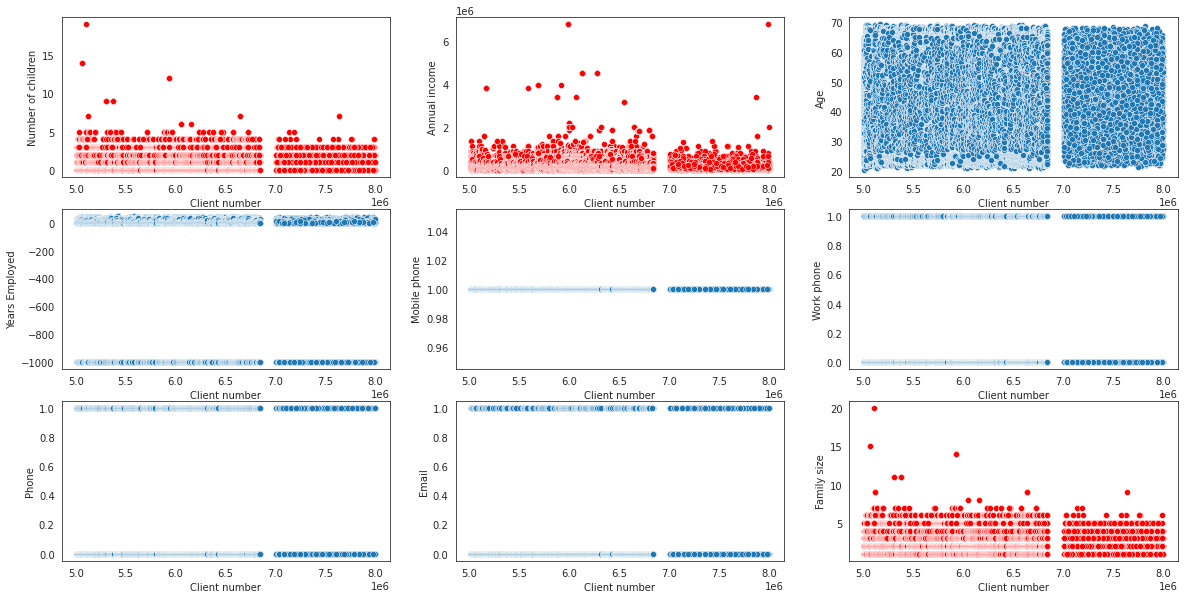

In [485]:
fig, ax= plt.subplots(nrows= 3, ncols = 3, figsize= (20,10))

sns.scatterplot(x='Client number', y='Number of children', data=data, ax=ax[0][0], color= 'red')
sns.scatterplot(x='Client number', y='Annual income', data=data, ax=ax[0][1], color='red')
sns.scatterplot(x='Client number', y='Age', data=data, ax=ax[0][2])
sns.scatterplot(x='Client number', y='Years Employed', data=data, ax=ax[1][0])
sns.scatterplot(x='Client number', y='Mobile phone', data=data, ax=ax[1][1])
sns.scatterplot(x='Client number', y='Work phone', data=data, ax=ax[1][2])
sns.scatterplot(x='Client number', y='Phone', data=data, ax=ax[2][0])
sns.scatterplot(x='Client number', y='Email', data=data, ax=ax[2][1])
sns.scatterplot(x='Client number', y='Family size', data=data, ax=ax[2][2], color= 'red')

There are some outliers within the plots in red - Number of Children, Annual Income, Family Size and Years Employed. It is highly likely that these may be error within the data collection and could cause errors during our prediction. Therefore, I will remove these clients.

In [486]:
def filter_function(df,col):
  # Calculate quantile range between 1-99
  q_low = df[col].quantile(0.01)
  q_hi  = df[col].quantile(0.99)
  # Remove data which lie outside the quantile range.
  return df[(df[col] < q_hi) & (df[col] > q_low)]

for col_name in ['Number of children', 'Annual income', 'Family size','Years Employed']:
  data = filter_function(data,col_name)
  
data.head()

,Client number,Own car,Own property,Number of children,Annual income,Age,Years Employed,Mobile phone,Work phone,Phone,Email,Family size,Gender_F,Gender_M,Income category_Commercial associate,Income category_Pensioner,Income category_State servant,Income category_Student,Income category_Working,Education level_Academic degree,Education level_Higher education,Education level_Incomplete higher,Education level_Lower secondary,Education level_Secondary / secondary special,Marital status_Civil marriage,Marital status_Married,Marital status_Separated,Marital status_Single / not married,Marital status_Widow,Way of living_Co-op apartment,Way of living_House / apartment,Way of living_Municipal apartment,Way of living_Office apartment,Way of living_Rented apartment,Way of living_With parents
29,5008838,0,1,1,405000.00,32.44,5.52,1,0,0,0,3.00,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
30,5008839,0,1,1,405000.00,32.44,5.52,1,0,0,0,3.00,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
31,5008840,0,1,1,405000.00,32.44,5.52,1,0,0,0,3.00,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
32,5008841,0,1,1,405000.00,32.44,5.52,1,0,0,0,3.00,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
33,5008842,0,1,1,405000.00,32.44,5.52,1,0,0,0,3.00,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0


<AxesSubplot:xlabel='Client number', ylabel='Family size'>

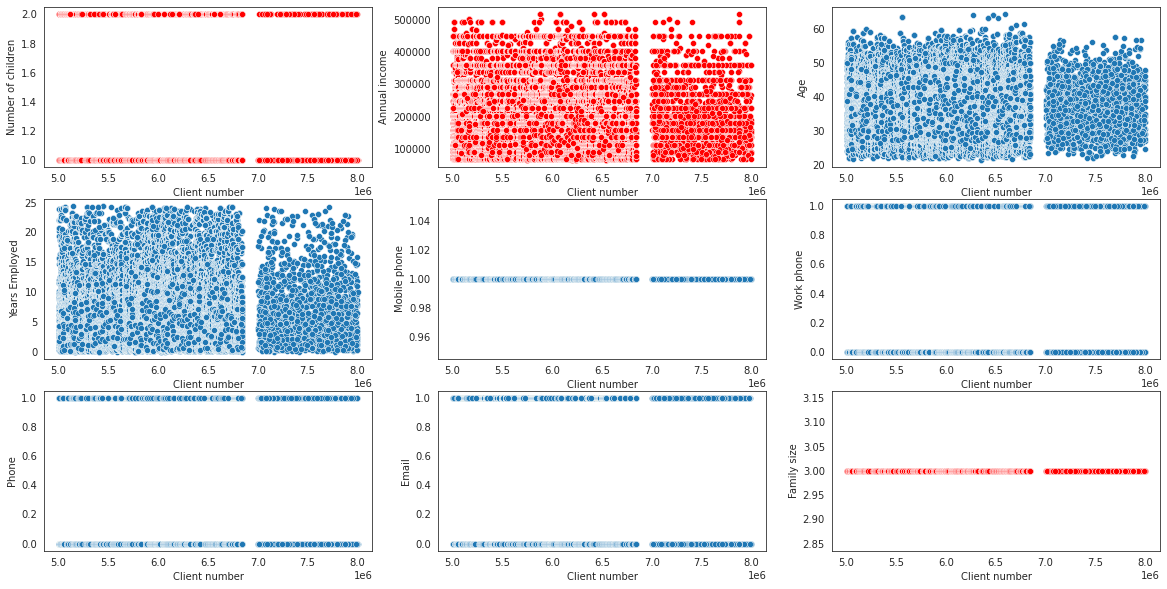

In [487]:
fig, ax= plt.subplots(nrows= 3, ncols = 3, figsize= (20,10))

sns.scatterplot(x='Client number', y='Number of children', data=data, ax=ax[0][0], color= 'red')
sns.scatterplot(x='Client number', y='Annual income', data=data, ax=ax[0][1], color='red')
sns.scatterplot(x='Client number', y='Age', data=data, ax=ax[0][2])
sns.scatterplot(x='Client number', y='Years Employed', data=data, ax=ax[1][0])
sns.scatterplot(x='Client number', y='Mobile phone', data=data, ax=ax[1][1])
sns.scatterplot(x='Client number', y='Work phone', data=data, ax=ax[1][2])
sns.scatterplot(x='Client number', y='Phone', data=data, ax=ax[2][0])
sns.scatterplot(x='Client number', y='Email', data=data, ax=ax[2][1])
sns.scatterplot(x='Client number', y='Family size', data=data, ax=ax[2][2], color= 'red')

Now we will take a look at the Credit Record dataset

In [488]:
# Check for null values
credit.isna().sum()

id           0
month_bal    0
status       0
dtype: int64

There are no null values in the credit data set. 
I will move on to assign scores based on the scoring system

In [489]:
credit['status'] = credit['status'].replace({'X':0})
credit['status'] = credit['status'].replace({'C':0.2})
credit.head()

,id,month_bal,status
0,5001711,0,0
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,0.20


In [490]:
# Function for scoring system
def scoring_function(x):
    if x > 1:
      return -x * 2
    elif x == 1:
      return -0.2
    else:
      return x

credit['status'] = credit['status'].replace({'C':0.2})
credit['status'] = credit['status'].astype(float)
credit['status'] = credit['status'].apply(scoring_function)
credit[credit['status'] < -3].head()

,id,month_bal,status
8911,5002126,-46,-4.00
8912,5002126,-47,-6.00
8913,5002126,-48,-6.00
8914,5002126,-49,-4.00
8915,5002126,-50,-4.00


Now we will get a total credit score of the customers and classify whether they should have been issued the credit card.

In [491]:
# Sum the total credit score of clients
new_credit = credit.groupby(["id"]).status.sum().reset_index()

#Create Function to determine if clients should be issued the card
def issue(row):
  # Check for favourable credit score
  if row['status'] >= 0:
    # Issue Card
    return 1
  else:
    # Don't issue card
    return 0

new_credit['Issue'] = new_credit.apply(lambda row: issue(row), axis = 1)
new_credit.drop(columns = 'status', inplace = True)
new_credit.head(10)

,id,Issue
0,5001711,1
1,5001712,1
2,5001713,1
3,5001714,1
4,5001715,1
5,5001717,1
6,5001718,1
7,5001719,1
8,5001720,0
9,5001723,1


In [492]:
# Check if output is correct
sum(credit[credit['id'] == 5001720]['status'])

-1.4

### Merge Data sets
We will merge the total data sets based on the Client's identification number

In [493]:
merged_data = data.join(new_credit.set_index('id'), on='Client number', how='inner')
merged_data.head(10)
merged_data.columns

Index(['Client number', 'Own car', 'Own property', 'Number of children',
       'Annual income', 'Age', 'Years Employed', 'Mobile phone', 'Work phone',
       'Phone', 'Email', 'Family size', 'Gender_F', 'Gender_M',
       'Income category_Commercial associate', 'Income category_Pensioner',
       'Income category_State servant', 'Income category_Student',
       'Income category_Working', 'Education level_Academic degree',
       'Education level_Higher education', 'Education level_Incomplete higher',
       'Education level_Lower secondary',
       'Education level_Secondary / secondary special',
       'Marital status_Civil marriage', 'Marital status_Married',
       'Marital status_Separated', 'Marital status_Single / not married',
       'Marital status_Widow', 'Way of living_Co-op apartment',
       'Way of living_House / apartment', 'Way of living_Municipal apartment',
       'Way of living_Office apartment', 'Way of living_Rented apartment',
       'Way of living_With parents',

In [494]:
# Normalize Data
colnames = merged_data.columns
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(merged_data)
merged_data = pd.DataFrame(x_scaled,columns = colnames)
merged_data


,Client number,Own car,Own property,Number of children,Annual income,Age,Years Employed,Mobile phone,Work phone,Phone,Email,Family size,Gender_F,Gender_M,Income category_Commercial associate,Income category_Pensioner,Income category_State servant,Income category_Student,Income category_Working,Education level_Academic degree,Education level_Higher education,Education level_Incomplete higher,Education level_Lower secondary,Education level_Secondary / secondary special,Marital status_Civil marriage,Marital status_Married,Marital status_Separated,Marital status_Single / not married,Marital status_Widow,Way of living_Co-op apartment,Way of living_House / apartment,Way of living_Municipal apartment,Way of living_Office apartment,Way of living_Rented apartment,Way of living_With parents,Issue
0,0.00,0.00,1.00,0.00,0.79,0.28,0.22,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
1,0.00,0.00,1.00,0.00,0.79,0.28,0.22,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
2,0.00,0.00,1.00,0.00,0.79,0.28,0.22,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
3,0.00,0.00,1.00,0.00,0.79,0.28,0.22,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
4,0.00,0.00,1.00,0.00,0.79,0.28,0.22,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6017,0.95,0.00,0.00,0.00,0.26,0.20,0.10,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
6018,0.95,0.00,0.00,0.00,0.26,0.20,0.10,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
6019,0.95,0.00,0.00,0.00,0.35,0.36,0.27,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
6020,0.97,0.00,1.00,0.00,0.44,0.70,0.14,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00


## Algorithm Implementation

Realistically, there is definitely vastly more good candidates than bad candidates. We can see the difference in the graph below

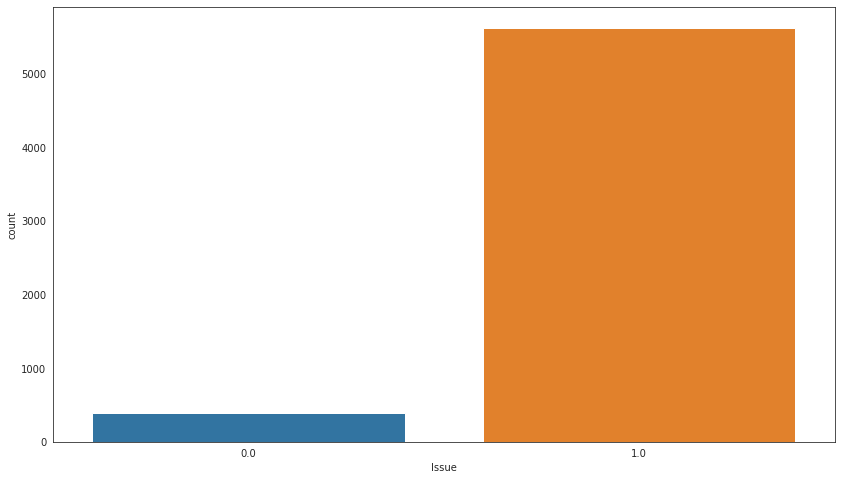

In [495]:
ax = plt.subplots(figsize= (14,8))
ax = sns.countplot(x="Issue", data= merged_data)

This means that our current data set is very imbalanced. There is a need to resample our data to ensure this is balanced out.

In [496]:
# Extract data without classification and Client Number 
X = merged_data.iloc[:,1:-1]
# Extract classification
y = merged_data.iloc[:,-1]

In [506]:
# Resample the data
oversample = SMOTE()
X_resampled, y_resampled = oversample.fit_resample(X,y)

<AxesSubplot:xlabel='Issue', ylabel='count'>

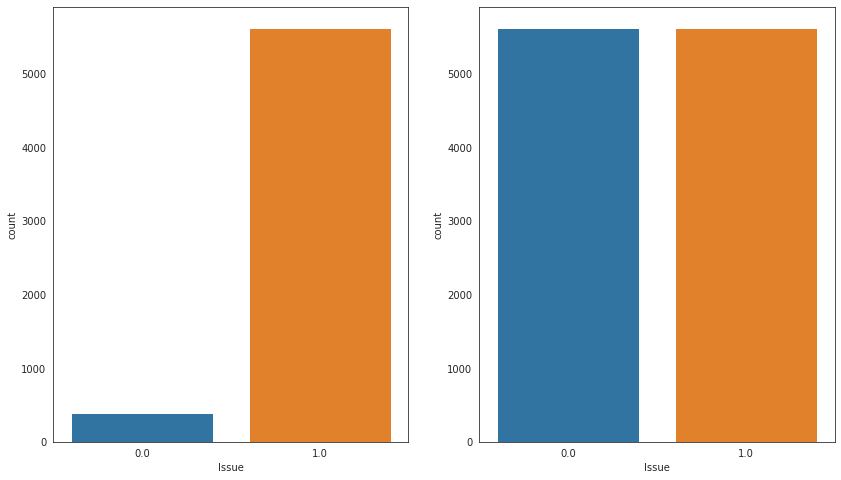

In [499]:
# Plot a comparision between before and after
fig, ax =plt.subplots(1,2, figsize = (14,8))
sns.countplot(y, ax = ax[0])
sns.countplot(y_resampled, ax = ax[1])

We can see that our sample issues has been solved through balancing.

# Algorithm Implementation
We will move on to implement our Machine Learning Models
- K-Nearest neighbors
- Random Forest
- Logistic Regression 
- Decision Trees
- XGBoost

In [500]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state = 49)

## K-Nearest neighbors


Accuracy Score is 0.67732


<AxesSubplot:>

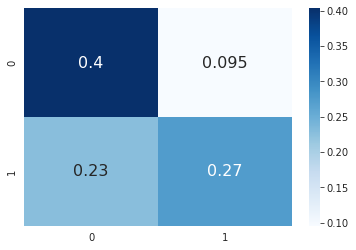

In [501]:
k = round((len(X_train))**0.5)
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
sns.heatmap(confusion_matrix(y_test,y_predict, normalize = 'all'),
            annot=True, annot_kws={"size": 16}, cmap = "Blues")

## Random Forest

Accuracy Score is 0.83622
     0    1
0  947  177
1  192  937


<AxesSubplot:>

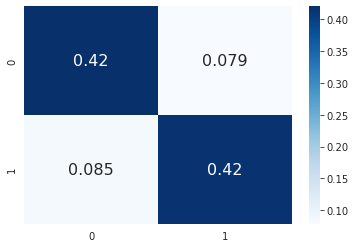

In [502]:
model = RandomForestClassifier(n_estimators=250,
                              max_depth=12,
                              min_samples_leaf=16
                              )
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

cm = confusion_matrix(y_test,y_predict)
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(cm))
sns.heatmap(confusion_matrix(y_test,y_predict, normalize = 'all'),
            annot=True, annot_kws={"size": 16}, cmap = "Blues")

### Logistic Regression

Accuracy Score is 0.5597
     0    1
0  682  442
1  550  579


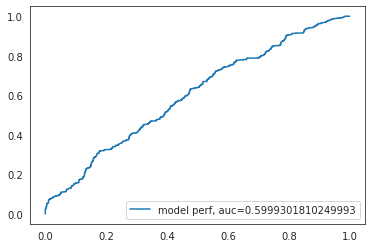

In [503]:
model = LogisticRegression(C=0.8,
                           random_state=0,
                           max_iter = 1000)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

#Plot AUC Curve
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="model perf, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Decision Tree

Accuracy Score is 0.75055
     0    1
0  907  217
1  345  784


<AxesSubplot:>

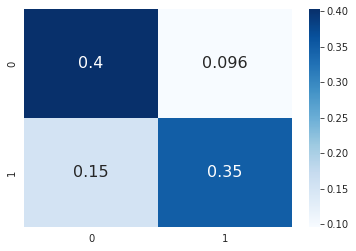

In [504]:
model = DecisionTreeClassifier(max_depth=12,
                               min_samples_split=8,
                               random_state=1024)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.heatmap(confusion_matrix(y_test,y_predict,normalize = 'all'),
            annot=True, annot_kws={"size": 16}, cmap = "Blues")

## XGBoost

Accuracy Score is 0.9281
      0     1
0  1046    78
1    84  1045


<AxesSubplot:>

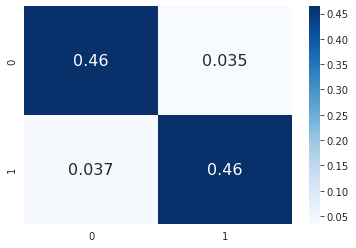

In [505]:
model = XGBClassifier(max_depth=12,
                      n_estimators=250,
                      min_child_weight=8, 
                      subsample=0.8, 
                      learning_rate =0.02,    
                      seed=42)

model.fit(X_train, y_train)
y_predict = model.predict(X_test)
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))
sns.heatmap(confusion_matrix(y_test,y_predict,normalize = 'all'),
            annot=True, annot_kws={"size": 16}, cmap = "Blues")

# Conclusion

Ultimately, with the information and our score system, I am able to achieve a 92% accuracy with XGBoost to determine if a client should be issued a credit card.